In [1]:
%load_ext autoreload
%autoreload 2

import os
import torch
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from pytorch_lightning import Trainer, seed_everything
from torchvision import transforms
from torchvision.datasets import MNIST
os.chdir("/nfs/homedirs/schwienb/project-4")

In [2]:
from src.data.mnist import MNISTDataModule, ConstantDataset, RandomDataset
from src.data.bg_aug_mnist import BgAugMNISTDataModule,BgAugFashionMNISTDataModule
from src.data.fashionmnist import FashionMNISTDataModule
from src.models.bg_aug_pixelcnn import BgAugPixelCNN
from src.models.pixelcnn import PixelCNN
from src.experiments.experiment import Experiment
from src.utils.pixelcnn import generate_images, draw_likelihood_plot, positionalencoding2d
from src.utils.ood_test import plot_roc_auc, test_ood
import torch.nn.functional as F

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
seed_everything(42)


42

In [4]:
experiment_name = 'PixelCNN_BgSub_D48_G_COCO_1'
dataset = FashionMNISTDataModule
ood_dataset = MNISTDataModule

In [5]:
exp = Experiment(experiment_name)

In [6]:
# exp._setup()
exp.load()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [ ]:
targets, results = test_ood(exp, dataset, ood_dataset)

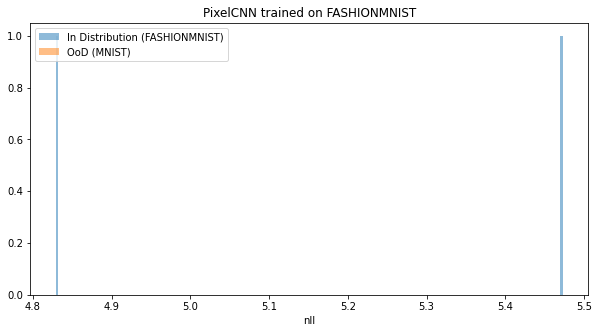

In [19]:
idd_losses = results[0:9999]
ood_losses = results[10000:20000]

plt.figure(figsize=(10,5))
bins = np.histogram(np.hstack((idd_losses,ood_losses)), bins=200)[1]
plt.hist(idd_losses, bins, alpha=0.5, label='In Distribution (FASHIONMNIST)')
plt.hist(ood_losses, bins, alpha=0.5, label='OoD (MNIST)')
plt.legend(loc='upper left')
plt.xlabel('nll')
plt.title('PixelCNN trained on FASHIONMNIST')
plt.show()

 ROC AUC=1.00000


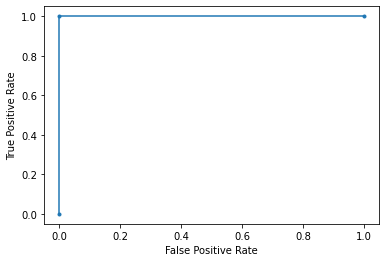

In [20]:
plot_roc_auc(targets, results)

## Evaluation without BgSub

In [21]:
exp.model.background_subtraction = False
targets2, results2 = test_ood(exp, dataset, ood_dataset)

Set SLURM handle signals.


/nfs/students/winter-term-2020/project-4/schwienb/conda/lib/python3.8/site-packages/torch/nn/functional.py:3060: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "
/nfs/students/winter-term-2020/project-4/schwienb/conda/lib/python3.8/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
Set SLURM handle signals.

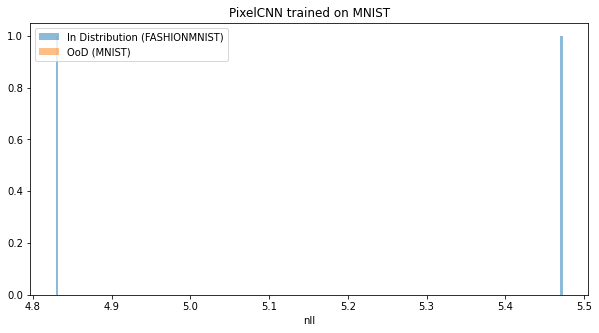

In [22]:
idd_losses = results2[0:9999]
ood_losses = results2[10000:20000]

plt.figure(figsize=(10,5))
bins = np.histogram(np.hstack((idd_losses,ood_losses)), bins=200)[1]
plt.hist(idd_losses, bins, alpha=0.5, label='In Distribution (FASHIONMNIST)')
plt.hist(ood_losses, bins, alpha=0.5, label='OoD (MNIST)')
plt.legend(loc='upper left')
plt.xlabel('nll')
plt.title('PixelCNN trained on MNIST')
plt.show()


 ROC AUC=1.00000


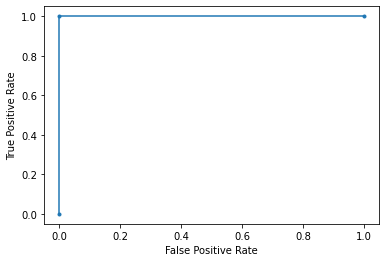

In [23]:
plot_roc_auc(targets2, results2)

## Pixel Likelihood

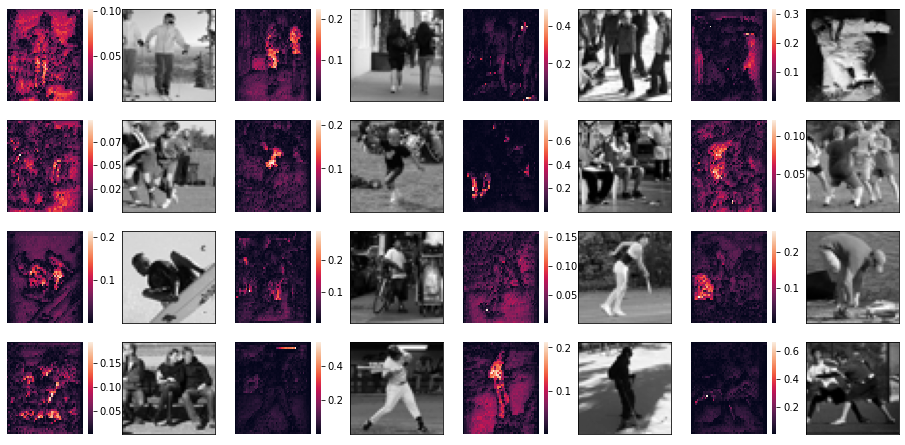

In [7]:
draw_likelihood_plot(exp.dataset.test_dataloader(), exp.model, cmap="rocket", vmax=None, img_index=0)

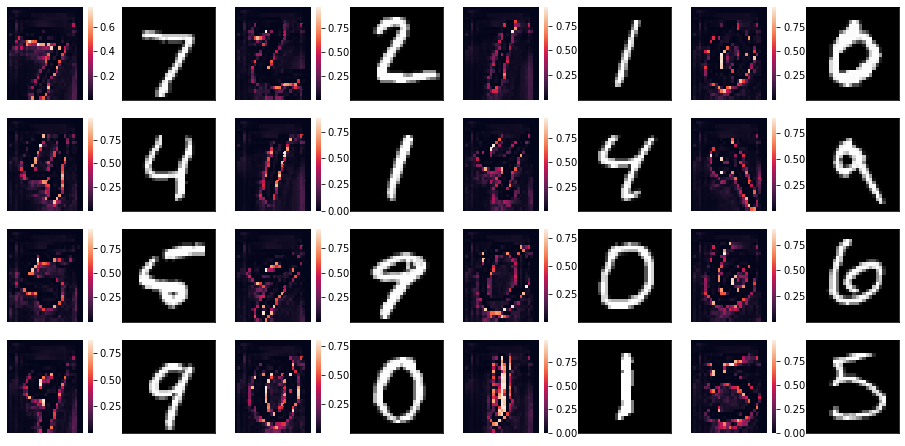

In [8]:
fm = MNISTDataModule()
fm.prepare_data()
fm.setup()

fm_test = fm.test_dataloader()
draw_likelihood_plot(fm_test, exp.model, cmap="rocket", vmax=None)

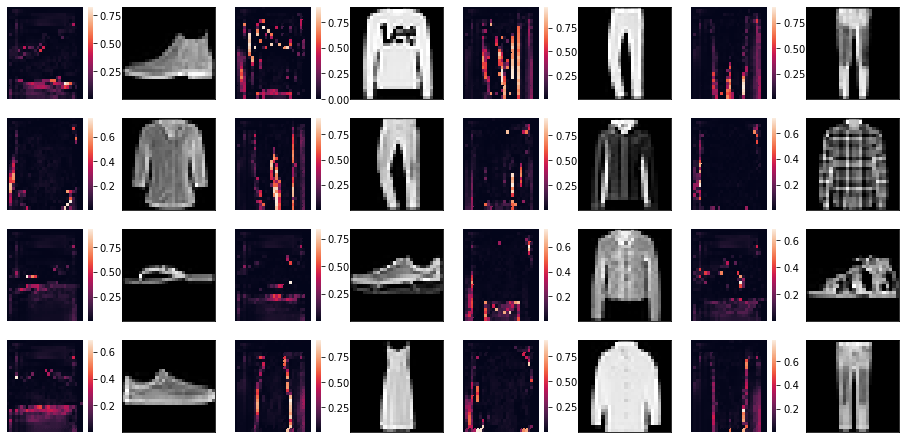

In [9]:
fm = FashionMNISTDataModule()
fm.prepare_data()
fm.setup()

fm_test = fm.test_dataloader()
draw_likelihood_plot(fm_test, exp.model, cmap="rocket", vmax=None)

## Generated images

/nfs/homedirs/schwienb/project-4/src/utils/pixelcnn.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(out[:, :, i, j]).data


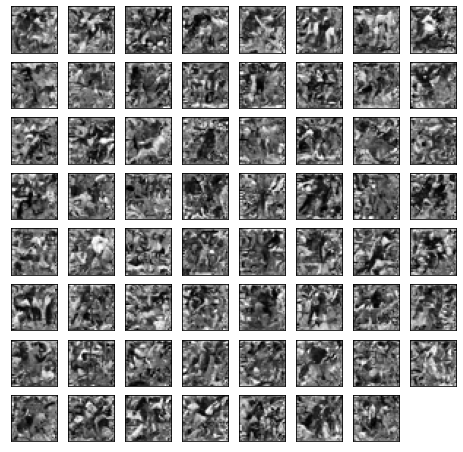

In [21]:
generate_images(exp.model, channels=1, img_dim=(32,32))